## 数据增广
- 很有必要，比如色温，亮度等的变化是很容易产生的，但是模型本身不应该对这些因素非常敏感
- 增加一个已有数据集，使得具有更多的多样性
- 数据增广一般是`在线生成`， 就是数据集读进去之后再数据增广
- 增广在有些情况下是为了去逼近测试集

- 高斯滤波分为高通滤波和低通滤波，高通滤波主要作用是锐化， 低通滤波主要作用是平滑

### 方法
1. 反转
   1. 上下翻转
   2. 左右翻转
2. 切割
   1. 切割出一块然后再变成固定形状
   2. 随机高宽比(e.g.[3/4, 4/3])
   3. 随机大小(e.g.[8%, 100%])
   4. 随机位置
3. 颜色
   1. 色调
   2. 饱和度
   3. 明亮度(e.g.[0.5, 1.5])

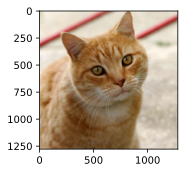

In [94]:
%matplotlib inline
import torch
import torchvision
from d2l import torch as d2l
from torch import nn
import torchvision.transforms as T

d2l.set_figsize()
img = d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img)

- 此函数在输入图像img上多次运行图像增广方法aug并显示所有结果

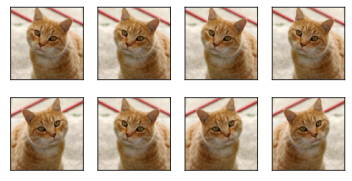

In [95]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

apply(img, T.RandomHorizontalFlip())

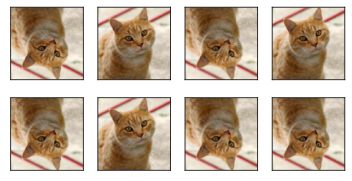

In [96]:
apply(img, T.RandomVerticalFlip())

- 我们可以通过裁剪降低模型对于图像中物体位置的敏感性

下面的代码将随机裁剪一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5～2之间随机取值。 然后，区域的宽度和高度都被缩放到200像素。

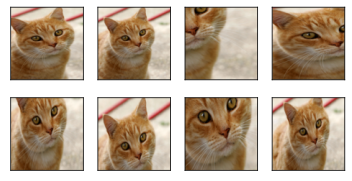

In [97]:
shaped_aug = T.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shaped_aug)

- 我们可以改变图像颜色的四个方面：  
    - 亮度
    - 对比度
    - 饱和度
    - 色调

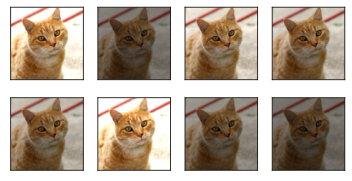

In [98]:
# 只改变亮度到原来的（0.5， 1.5）
apply(img, T.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

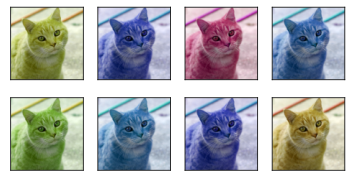

In [99]:
# 只改变色调
apply(img, T.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

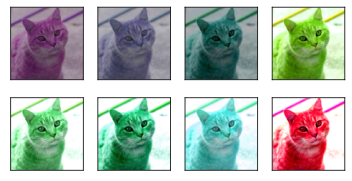

In [100]:
color_aug = T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

- 结合多种图像增广的方法

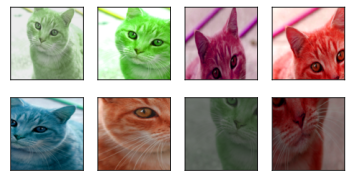

In [101]:
augs = T.Compose([
    T.RandomHorizontalFlip(), shaped_aug, color_aug
])
apply(img, augs)

- 使用图像增广进行训练

Files already downloaded and verified


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

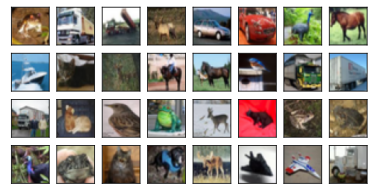

In [102]:
all_images = torchvision.datasets.CIFAR10(root='../data', train=True, download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

In [103]:
import torch.utils
import torch.utils.data


train_augs = T.Compose([
    T.RandomHorizontalFlip(),
    T.ToTensor()
])
test_augs = T.Compose([
    T.ToTensor()
])

def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root='../data', train=is_train, transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train, 
                                             num_workers=d2l.get_dataloader_workers())
    return dataloader

In [ ]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum


def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, batch_size, 
               devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator('epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train_loss', 'train_acc', 'test,acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度，训练损失，训练精度，实例数，特征数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc 'f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on 'f'{str(devices)}')

In [116]:
num_epochs, batch_size, net , devices = 10, 256, d2l.resnet18(10, 3), d2l.try_all_gpus()

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_normal_(m.weight)

net.apply(init_weights)

def train_with_augs(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    trainer = torch.optim.Adam(net.parameters(), lr)
    loss = nn.CrossEntropyLoss(reduction='none')
    train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, batch_size)

d2l.try_all_gpus()

[device(type='cuda', index=0), device(type='cuda', index=1)]

loss 0.174, train acc 0.940, test acc 0.838
3678.4 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


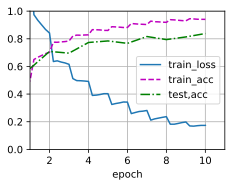

In [117]:
train_with_augs(train_augs, test_augs, net)